# mcu_basic_tuning
In this notebook, we'll train and evaluate variations of the baseline model, with a single parameter or attribute tuned, to see how that affects model performance. These insights will be used further on in the modeling process.

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.dummy import DummyClassifier
import tensorflow as tf
import metric_functions as mf

# Compile and Create Image Data <a id='data'></a>

## Identify Working Directory

In [2]:
# dataset with 60% of non-MCU frames removed from Training data
working_directory = 'mixed_frames_remove_60'

In [3]:
train_folder = os.path.join('mcu_data', working_directory, 'train')
train_mcu = os.path.join(train_folder, 'mcu')
train_non = os.path.join(train_folder, 'non_mcu')

test_folder = os.path.join('mcu_data', working_directory, 'test')
test_mcu = os.path.join(test_folder, 'mcu')
test_non = os.path.join(test_folder, 'non_mcu')

print('There are', len(os.listdir(train_mcu)) + len(os.listdir(train_non)), 'images in the Train set')
print('There are', len(os.listdir(test_mcu)) + len(os.listdir(test_non)), 'images in the Test set')

print('\n')

print('There are', len(os.listdir(train_mcu)), 'MCU images in the train set')
print('There are', len(os.listdir(train_non)), 'non-MCU images in the train set')
print('There are', len(os.listdir(test_mcu)), 'MCU images in the test set')
print('There are', len(os.listdir(test_non)), 'non-MCU images in the test set')

There are 5111 images in the Train set
There are 2285 images in the Test set


There are 2419 MCU images in the train set
There are 2692 non-MCU images in the train set
There are 604 MCU images in the test set
There are 1681 non-MCU images in the test set


### Create input data with image size of 128 x 128

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 4090,
    color_mode = 'grayscale',
    subset = 'training')

val_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 1021,
    color_mode = 'grayscale',
    subset = 'validation')

Found 4090 images belonging to 2 classes.
Found 1021 images belonging to 2 classes.


In [5]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 2285)

Found 2285 images belonging to 2 classes.


In [6]:
class_labels = ['Non-MCU', 'MCU']
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)
train_y = np.reshape(train_labels[:,0], (4090,1))
val_y = np.reshape(val_labels[:,0], (1021,1))
test_y = np.reshape(test_labels[:,0], (2285,1))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

train_images shape: (4090, 128, 128, 1)
train_labels shape: (4090, 2)
val_images shape: (1021, 128, 128, 1)
val_labels shape: (1021, 2)
test_images shape: (2285, 128, 128, 1)
test_labels shape: (2285, 2)


# Dummy Classifier
As a simple baseline, a DummyClassifier is "trained" on the training data, and "tested" on the test data. It's arguably just a coin flip.

In [18]:
dummy_clf_strat = DummyClassifier(strategy='stratified')
dummy_clf_strat.fit(train_images, train_y)
dummy_score = dummy_clf_strat.score(test_images, test_y)
print('{0:.2f}%'.format(dummy_score * 100))

50.63%


# Baseline Model
This model design was built and tested in another notebook "mcu_baseline_creation", evaluted against 8 other model/data designs. It is replicated here for clarity. It contains a maximum CNN layer of 6x6, sampling and pooling down until the 3x3 CNN layer.

In [11]:
model_baseline = models.Sequential()
model_baseline.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_baseline.add(layers.MaxPooling2D((2, 2)))

model_baseline.add(layers.Flatten())
model_baseline.add(layers.Dense(64, activation='relu'))
model_baseline.add(layers.Dense(1, activation='sigmoid'))

model_baseline.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [12]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_baseline = model_baseline.fit(train_images,
                                    train_y,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images, val_y),
                                    callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.6976 - acc: 0.5208 - val_loss: 0.6715 - val_acc: 0.6376
Epoch 2/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6755 - acc: 0.5863 - val_loss: 0.6502 - val_acc: 0.6611
Epoch 3/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6572 - acc: 0.6134 - val_loss: 0.6360 - val_acc: 0.6200
Epoch 4/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6389 - acc: 0.6367 - val_loss: 0.6249 - val_acc: 0.6464
Epoch 5/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6180 - acc: 0.6677 - val_loss: 0.5905 - val_acc: 0.7042
Epoch 6/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6009 - acc: 0.6824 - val_loss: 0.5523 - val_acc: 0.7473
Epoch 7/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5512 - acc: 0.7169 - val_loss: 0.5589 - val_acc: 0.7111
Epoch 8/50
409

Accuracy 
 Train: 0.853, Test: 0.649
Loss 
 Train: 0.318, Test: 0.849 



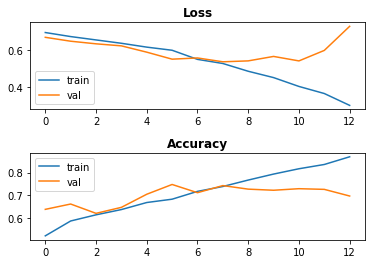



Confusion Matrix, without normalization


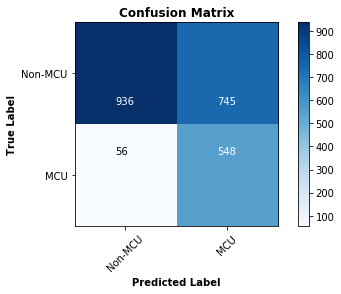



              precision    recall  f1-score   support

     Non-MCU       0.94      0.56      0.70      1681
         MCU       0.42      0.91      0.58       604

    accuracy                           0.65      2285
   macro avg       0.68      0.73      0.64      2285
weighted avg       0.81      0.65      0.67      2285



In [13]:
print(mf.evaluate_test(model_baseline, history_baseline, class_labels, train_images, test_images, train_y, test_y))

# Units
In this section, we'll be seeing the effects of increasing the number of units/filters per layer. I'll be modifying units in these categories:

- Input Layer
- Hidden Layers
- Activation layer (in classifier)

## Input Layer, x2
First, we double the amount of filters in the CNN's input layer to observe its impact.

In [14]:
model_units_input_x2 = models.Sequential()
model_units_input_x2.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_units_input_x2.add(layers.MaxPooling2D((2, 2)))

model_units_input_x2.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_units_input_x2.add(layers.MaxPooling2D((2, 2)))

model_units_input_x2.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_units_input_x2.add(layers.MaxPooling2D((2, 2)))

model_units_input_x2.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_units_input_x2.add(layers.MaxPooling2D((2, 2)))

model_units_input_x2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_units_input_x2.add(layers.MaxPooling2D((2, 2)))

model_units_input_x2.add(layers.Flatten())
model_units_input_x2.add(layers.Dense(64, activation='relu'))
model_units_input_x2.add(layers.Dense(1, activation='sigmoid'))

model_units_input_x2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [15]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_units_input_x2 = model_units_input_x2.fit(train_images,
                                                 train_y,
                                                 epochs=50,
                                                 batch_size=50,
                                                 validation_data=(val_images, val_y),
                                                 callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.7017 - acc: 0.5237 - val_loss: 0.6754 - val_acc: 0.6141
Epoch 2/50
4090/4090 [==============================] - 9s 2ms/step - loss: 0.6759 - acc: 0.5694 - val_loss: 0.6581 - val_acc: 0.6445
Epoch 3/50
4090/4090 [==============================] - 9s 2ms/step - loss: 0.6625 - acc: 0.6051 - val_loss: 0.6297 - val_acc: 0.6729
Epoch 4/50
4090/4090 [==============================] - 9s 2ms/step - loss: 0.6447 - acc: 0.6389 - val_loss: 0.6369 - val_acc: 0.5837
Epoch 5/50
4090/4090 [==============================] - 9s 2ms/step - loss: 0.6280 - acc: 0.6533 - val_loss: 0.5661 - val_acc: 0.7120
Epoch 6/50
4090/4090 [==============================] - 9s 2ms/step - loss: 0.5944 - acc: 0.6958 - val_loss: 0.5531 - val_acc: 0.7238
Epoch 7/50
4090/4090 [==============================] - 9s 2ms/step - loss: 0.5619 - acc: 0.7164 - val_loss: 0.5471 - val_acc: 0.7130
Epoch 8/50
40

Accuracy 
 Train: 0.884, Test: 0.796
Loss 
 Train: 0.269, Test: 0.486 



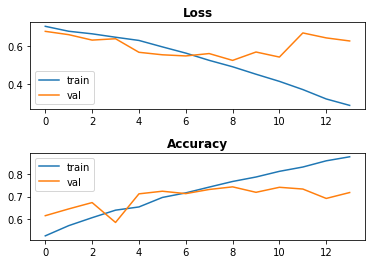



Confusion Matrix, without normalization


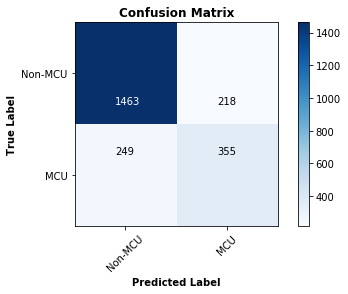



              precision    recall  f1-score   support

     Non-MCU       0.85      0.87      0.86      1681
         MCU       0.62      0.59      0.60       604

    accuracy                           0.80      2285
   macro avg       0.74      0.73      0.73      2285
weighted avg       0.79      0.80      0.79      2285



In [16]:
print(mf.evaluate_test(model_units_input_x2, history_units_input_x2, class_labels, train_images, test_images, train_y, test_y))

This resulted in a substantial hit to MCU recall. We'll leave this for now, but may choose to return to this during final modeling, as it may be appropriate to increase the number of filters in the Input Layer, if we increase the number of filters in the Hidden layers. 

## Hidden Layers, x2
We double the amount of filters at each Hidden Layer. However, to maintain the correct shape of a CNN, we double the amount of filters at the smallest (3x3) CNN layer, and double predeccesor CNN layers only if they maintain the doubling pattern (256->128->64).

In [9]:
model_units_hidden_x2 = models.Sequential()
model_units_hidden_x2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_units_hidden_x2.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x2.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_units_hidden_x2.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x2.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_units_hidden_x2.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x2.add(layers.Conv2D(128, (4, 4), activation='relu'))
model_units_hidden_x2.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_units_hidden_x2.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x2.add(layers.Flatten())
model_units_hidden_x2.add(layers.Dense(64, activation='relu'))
model_units_hidden_x2.add(layers.Dense(1, activation='sigmoid'))

model_units_hidden_x2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [10]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_units_hidden_x2 = model_units_hidden_x2.fit(train_images,
                                                 train_y,
                                                 epochs=50,
                                                 batch_size=50,
                                                 validation_data=(val_images, val_y),
                                                 callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.7268 - acc: 0.5289 - val_loss: 0.6811 - val_acc: 0.6425
Epoch 2/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6872 - acc: 0.5758 - val_loss: 0.6576 - val_acc: 0.6229
Epoch 3/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6646 - acc: 0.6005 - val_loss: 0.6199 - val_acc: 0.6827
Epoch 4/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6387 - acc: 0.6513 - val_loss: 0.5884 - val_acc: 0.7062
Epoch 5/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6155 - acc: 0.6697 - val_loss: 0.5749 - val_acc: 0.7267
Epoch 6/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5866 - acc: 0.7054 - val_loss: 0.6981 - val_acc: 0.6425
Epoch 7/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5453 - acc: 0.7313 - val_loss: 0.6528 - val_acc: 0.6582
Epoch 8/50
409

Accuracy 
 Train: 0.978, Test: 0.773
Loss 
 Train: 0.065, Test: 0.898 



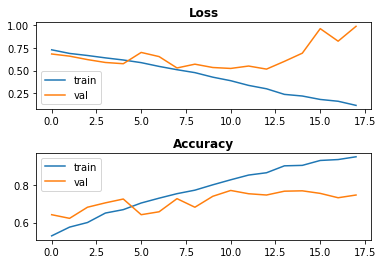



Confusion Matrix, without normalization


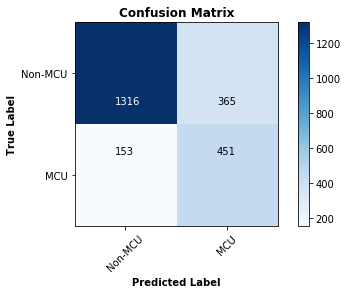



              precision    recall  f1-score   support

     Non-MCU       0.90      0.78      0.84      1681
         MCU       0.55      0.75      0.64       604

    accuracy                           0.77      2285
   macro avg       0.72      0.76      0.74      2285
weighted avg       0.81      0.77      0.78      2285



In [12]:
print(mf.evaluate_test(model_units_hidden_x2, history_units_hidden_x2, class_labels, train_images, test_images, train_y, test_y))

## Hidden Layers, x4
Doubling the amount of Hidden Layers gave us a sample reduction in False Positives, with a trade-off of MCU recall. Let's take this a little further by multiplying the Hidden Layers x8.

In [13]:
model_units_hidden_x4 = models.Sequential()
model_units_hidden_x4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_units_hidden_x4.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x4.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_units_hidden_x4.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x4.add(layers.Conv2D(128, (5, 5), activation='relu'))
model_units_hidden_x4.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x4.add(layers.Conv2D(256, (4, 4), activation='relu'))
model_units_hidden_x4.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x4.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_units_hidden_x4.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x4.add(layers.Flatten())
model_units_hidden_x4.add(layers.Dense(64, activation='relu'))
model_units_hidden_x4.add(layers.Dense(1, activation='sigmoid'))

model_units_hidden_x4.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [14]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_units_hidden_x4 = model_units_hidden_x4.fit(train_images,
                                                 train_y,
                                                 epochs=50,
                                                 batch_size=50,
                                                 validation_data=(val_images, val_y),
                                                 callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.7125 - acc: 0.5384 - val_loss: 0.6930 - val_acc: 0.5279
Epoch 2/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6894 - acc: 0.5731 - val_loss: 0.6418 - val_acc: 0.6552
Epoch 3/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6532 - acc: 0.6267 - val_loss: 0.6101 - val_acc: 0.6856
Epoch 4/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6329 - acc: 0.6572 - val_loss: 0.6393 - val_acc: 0.6043
Epoch 5/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.6215 - acc: 0.6729 - val_loss: 0.5602 - val_acc: 0.7238
Epoch 6/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.5880 - acc: 0.6961 - val_loss: 0.5545 - val_acc: 0.7248
Epoch 7/50
4090/4090 [==============================] - 7s 2ms/step - loss: 0.5698 - acc: 0.7134 - val_loss: 0.5621 - val_acc: 0.7169
Epoch 8/50
409

Accuracy 
 Train: 0.939, Test: 0.743
Loss 
 Train: 0.166, Test: 0.655 



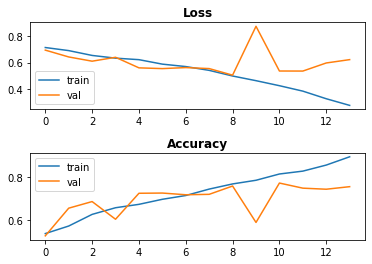



Confusion Matrix, without normalization


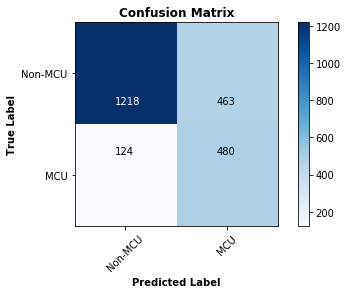



              precision    recall  f1-score   support

     Non-MCU       0.91      0.72      0.81      1681
         MCU       0.51      0.79      0.62       604

    accuracy                           0.74      2285
   macro avg       0.71      0.76      0.71      2285
weighted avg       0.80      0.74      0.76      2285



In [15]:
print(mf.evaluate_test(model_units_hidden_x4, history_units_hidden_x4, class_labels, train_images, test_images, train_y, test_y))

## Hidden Layers, x8
Doubling the Hidden Layers again to x4 gave us higher MCU recall (though still lower than baseline). Let's do this one more time by setting Hidden Layers x8.

In [16]:
model_units_hidden_x8 = models.Sequential()
model_units_hidden_x8.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_units_hidden_x8.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x8.add(layers.Conv2D(128, (6, 6), activation='relu'))
model_units_hidden_x8.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x8.add(layers.Conv2D(256, (5, 5), activation='relu'))
model_units_hidden_x8.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x8.add(layers.Conv2D(512, (4, 4), activation='relu'))
model_units_hidden_x8.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x8.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model_units_hidden_x8.add(layers.MaxPooling2D((2, 2)))

model_units_hidden_x8.add(layers.Flatten())
model_units_hidden_x8.add(layers.Dense(64, activation='relu'))
model_units_hidden_x8.add(layers.Dense(1, activation='sigmoid'))

model_units_hidden_x8.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [17]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_units_hidden_x8 = model_units_hidden_x8.fit(train_images,
                                                 train_y,
                                                 epochs=50,
                                                 batch_size=50,
                                                 validation_data=(val_images, val_y),
                                                 callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 13s 3ms/step - loss: 0.9458 - acc: 0.5237 - val_loss: 0.6989 - val_acc: 0.4995
Epoch 2/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.6939 - acc: 0.5780 - val_loss: 0.6444 - val_acc: 0.6611
Epoch 3/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.6720 - acc: 0.5983 - val_loss: 0.6772 - val_acc: 0.5260
Epoch 4/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.6451 - acc: 0.6403 - val_loss: 0.6138 - val_acc: 0.7052
Epoch 5/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.6276 - acc: 0.6604 - val_loss: 0.5840 - val_acc: 0.7228
Epoch 6/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.6138 - acc: 0.6817 - val_loss: 0.5752 - val_acc: 0.6954
Epoch 7/50
4090/4090 [==============================] - 11s 3ms/step - loss: 0.5847 - acc: 0.7034 - val_loss: 0.5820 - val_acc: 0.7375
Epoch 8

Accuracy 
 Train: 0.859, Test: 0.725
Loss 
 Train: 0.363, Test: 0.747 



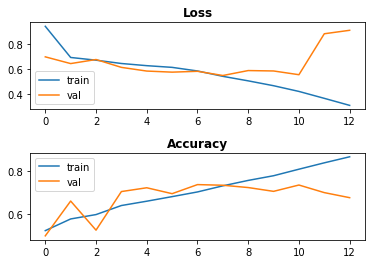



Confusion Matrix, without normalization


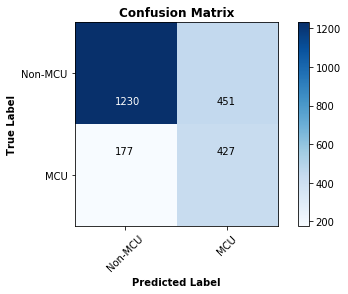



              precision    recall  f1-score   support

     Non-MCU       0.87      0.73      0.80      1681
         MCU       0.49      0.71      0.58       604

    accuracy                           0.73      2285
   macro avg       0.68      0.72      0.69      2285
weighted avg       0.77      0.73      0.74      2285



In [18]:
print(mf.evaluate_test(model_units_hidden_x8, history_units_hidden_x8, class_labels, train_images, test_images, train_y, test_y))

x8 Hidden Layer filters resulted in a substantial decrease in MCU recall. x4 was probably the sweet spot.

## Activation Layer, x2
Next, let's see the impact of doubling the amount of filters at the classifier's Activation Layer.

In [21]:
model_units_activation_x2 = models.Sequential()
model_units_activation_x2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_units_activation_x2.add(layers.MaxPooling2D((2, 2)))

model_units_activation_x2.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_units_activation_x2.add(layers.MaxPooling2D((2, 2)))

model_units_activation_x2.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_units_activation_x2.add(layers.MaxPooling2D((2, 2)))

model_units_activation_x2.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_units_activation_x2.add(layers.MaxPooling2D((2, 2)))

model_units_activation_x2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_units_activation_x2.add(layers.MaxPooling2D((2, 2)))

model_units_activation_x2.add(layers.Flatten())
model_units_activation_x2.add(layers.Dense(128, activation='relu'))
model_units_activation_x2.add(layers.Dense(1, activation='sigmoid'))

model_units_activation_x2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [22]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_units_activation_x2 = model_units_activation_x2.fit(train_images,
                                                 train_y,
                                                 epochs=50,
                                                 batch_size=50,
                                                 validation_data=(val_images, val_y),
                                                 callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6926 - acc: 0.5345 - val_loss: 0.6734 - val_acc: 0.6249
Epoch 2/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6751 - acc: 0.5971 - val_loss: 0.6301 - val_acc: 0.6513
Epoch 3/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6591 - acc: 0.6232 - val_loss: 0.6151 - val_acc: 0.6934
Epoch 4/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6269 - acc: 0.6582 - val_loss: 0.5577 - val_acc: 0.7287
Epoch 5/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5933 - acc: 0.6976 - val_loss: 0.5538 - val_acc: 0.7062
Epoch 6/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5699 - acc: 0.7134 - val_loss: 0.5693 - val_acc: 0.7062
Epoch 7/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5355 - acc: 0.7369 - val_loss: 0.5126 - val_acc: 0.7571
Epoch 8/50
409

Accuracy 
 Train: 0.849, Test: 0.675
Loss 
 Train: 0.365, Test: 0.899 



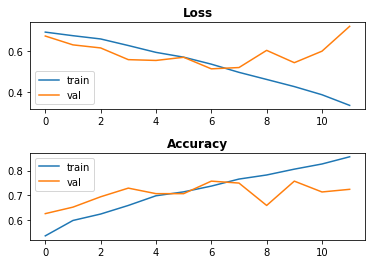



Confusion Matrix, without normalization


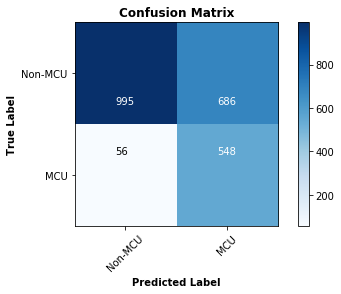



              precision    recall  f1-score   support

     Non-MCU       0.95      0.59      0.73      1681
         MCU       0.44      0.91      0.60       604

    accuracy                           0.68      2285
   macro avg       0.70      0.75      0.66      2285
weighted avg       0.81      0.68      0.69      2285



In [23]:
print(mf.evaluate_test(model_units_activation_x2, history_units_activation_x2, class_labels, train_images, test_images, train_y, test_y))

Doubling the units at the classifier's Activation Layer really helped the MCU recall, though it might be producing too many false positives. We'll warily try it during modeling.

# Regularization/Normalization
## Dropout before Flatten
Next, we'll apply regularization and normalization techniques, namely Dropout and Batch Normalization. First, Dropout of 50% before the Flatten layer, in between the convolution layers and then classifier.

In [27]:
model_baseline_dropout_before = models.Sequential()
model_baseline_dropout_before.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_baseline_dropout_before.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_before.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_baseline_dropout_before.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_before.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_baseline_dropout_before.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_before.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_baseline_dropout_before.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_before.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_baseline_dropout_before.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_before.add(Dropout(.5))
model_baseline_dropout_before.add(layers.Flatten())
model_baseline_dropout_before.add(layers.Dense(64, activation='relu'))
model_baseline_dropout_before.add(layers.Dense(1, activation='sigmoid'))

model_baseline_dropout_before.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [28]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_baseline_dropout_before = model_baseline_dropout_before.fit(train_images,
                                                 train_y,
                                                 epochs=50,
                                                 batch_size=50,
                                                 validation_data=(val_images, val_y),
                                                 callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6893 - acc: 0.5457 - val_loss: 0.6581 - val_acc: 0.6357
Epoch 2/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6666 - acc: 0.6032 - val_loss: 0.6371 - val_acc: 0.5965
Epoch 3/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6581 - acc: 0.6271 - val_loss: 0.6141 - val_acc: 0.6905
Epoch 4/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6458 - acc: 0.6333 - val_loss: 0.6035 - val_acc: 0.7169
Epoch 5/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6369 - acc: 0.6572 - val_loss: 0.5890 - val_acc: 0.7042
Epoch 6/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6019 - acc: 0.6853 - val_loss: 0.5709 - val_acc: 0.7032
Epoch 7/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5837 - acc: 0.7056 - val_loss: 0.5407 - val_acc: 0.7444
Epoch 8/50
409

Accuracy 
 Train: 0.870, Test: 0.794
Loss 
 Train: 0.296, Test: 0.562 



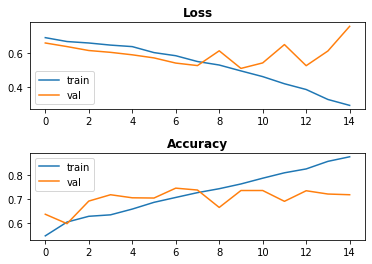



Confusion Matrix, without normalization


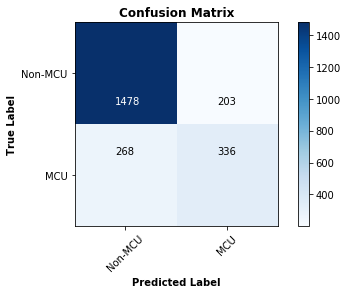



              precision    recall  f1-score   support

     Non-MCU       0.85      0.88      0.86      1681
         MCU       0.62      0.56      0.59       604

    accuracy                           0.79      2285
   macro avg       0.73      0.72      0.73      2285
weighted avg       0.79      0.79      0.79      2285



In [29]:
print(mf.evaluate_test(model_baseline_dropout_before, history_baseline_dropout_before, class_labels, train_images, test_images, train_y, test_y))

## Dropout after activation
Applying Dropout before the Flatten layer reduced MCU recall substantially. Let's try it after the classifier's relu activation.

In [30]:
model_baseline_dropout_after = models.Sequential()
model_baseline_dropout_after.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_baseline_dropout_after.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_after.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_baseline_dropout_after.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_after.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_baseline_dropout_after.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_after.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_baseline_dropout_after.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_after.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_baseline_dropout_after.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_after.add(layers.Flatten())
model_baseline_dropout_after.add(layers.Dense(64, activation='relu'))
model_baseline_dropout_after.add(Dropout(.5))
model_baseline_dropout_after.add(layers.Dense(1, activation='sigmoid'))

model_baseline_dropout_after.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [31]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_baseline_dropout_after = model_baseline_dropout_after.fit(train_images,
                                                 train_y,
                                                 epochs=50,
                                                 batch_size=50,
                                                 validation_data=(val_images, val_y),
                                                 callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6927 - acc: 0.5315 - val_loss: 0.6647 - val_acc: 0.5328
Epoch 2/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6744 - acc: 0.5900 - val_loss: 0.6406 - val_acc: 0.6229
Epoch 3/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6519 - acc: 0.6289 - val_loss: 0.5980 - val_acc: 0.7062
Epoch 4/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6412 - acc: 0.6477 - val_loss: 0.6304 - val_acc: 0.6376
Epoch 5/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6201 - acc: 0.6709 - val_loss: 0.6238 - val_acc: 0.6650
Epoch 6/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5886 - acc: 0.6985 - val_loss: 0.5792 - val_acc: 0.6983
Epoch 7/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5713 - acc: 0.7105 - val_loss: 0.5597 - val_acc: 0.7218
Epoch 8/50
409

Accuracy 
 Train: 0.936, Test: 0.684
Loss 
 Train: 0.171, Test: 1.010 



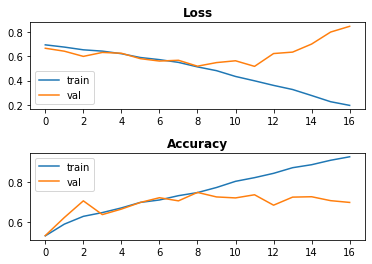



Confusion Matrix, without normalization


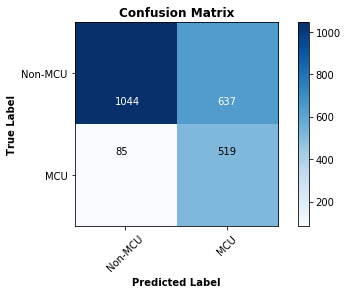



              precision    recall  f1-score   support

     Non-MCU       0.92      0.62      0.74      1681
         MCU       0.45      0.86      0.59       604

    accuracy                           0.68      2285
   macro avg       0.69      0.74      0.67      2285
weighted avg       0.80      0.68      0.70      2285



In [32]:
print(mf.evaluate_test(model_baseline_dropout_after, history_baseline_dropout_after, class_labels, train_images, test_images, train_y, test_y))

## Double Dropout
That preserved MCU recall substantially but also raised the False Probability to an unacceptable rate. Perhaps there's a sweet spot by applying both.

In [33]:
model_baseline_dropout_double = models.Sequential()
model_baseline_dropout_double.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_baseline_dropout_double.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_double.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_baseline_dropout_double.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_double.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_baseline_dropout_double.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_double.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_baseline_dropout_double.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_double.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_baseline_dropout_double.add(layers.MaxPooling2D((2, 2)))

model_baseline_dropout_double.add(Dropout(.5))
model_baseline_dropout_double.add(layers.Flatten())
model_baseline_dropout_double.add(layers.Dense(64, activation='relu'))
model_baseline_dropout_double.add(Dropout(.5))
model_baseline_dropout_double.add(layers.Dense(1, activation='sigmoid'))

model_baseline_dropout_double.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [34]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_baseline_dropout_double = model_baseline_dropout_double.fit(train_images,
                                                 train_y,
                                                 epochs=50,
                                                 batch_size=50,
                                                 validation_data=(val_images, val_y),
                                                 callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.7019 - acc: 0.5281 - val_loss: 0.6662 - val_acc: 0.5250
Epoch 2/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6724 - acc: 0.5800 - val_loss: 0.6392 - val_acc: 0.6562
Epoch 3/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6669 - acc: 0.6125 - val_loss: 0.6220 - val_acc: 0.6533
Epoch 4/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6500 - acc: 0.6330 - val_loss: 0.6061 - val_acc: 0.7062
Epoch 5/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6330 - acc: 0.6491 - val_loss: 0.5745 - val_acc: 0.7258
Epoch 6/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6157 - acc: 0.6802 - val_loss: 0.5592 - val_acc: 0.7120
Epoch 7/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5946 - acc: 0.6822 - val_loss: 0.5846 - val_acc: 0.6895
Epoch 8/50
409

Accuracy 
 Train: 0.951, Test: 0.779
Loss 
 Train: 0.130, Test: 0.644 



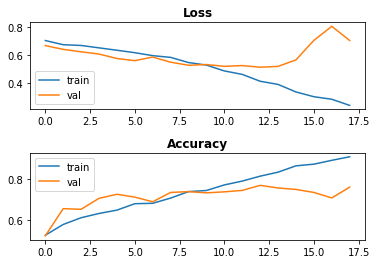



Confusion Matrix, without normalization


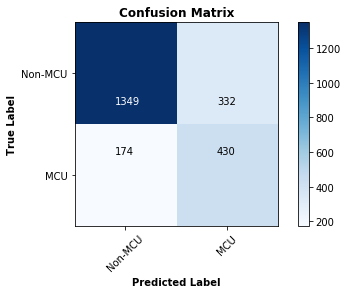



              precision    recall  f1-score   support

     Non-MCU       0.89      0.80      0.84      1681
         MCU       0.56      0.71      0.63       604

    accuracy                           0.78      2285
   macro avg       0.73      0.76      0.74      2285
weighted avg       0.80      0.78      0.79      2285



In [35]:
print(mf.evaluate_test(model_baseline_dropout_double, history_baseline_dropout_double, class_labels, train_images, test_images, train_y, test_y))

Double Dropout seemed balanced between reducing False Positives and increasing MCU Recall (though not as substantial a Recall increase as hoped). We'll try both Double Dropout and Dropout after the classifier relu layer during modeling.

## Batch Normalization between Convolution and Pooling
Next, we'll experiment with Batch Normalization layers. First, we'll put them in between the Conv2D and MaxPooling2D layers.

In [37]:
model_baseline_batch_hidden = models.Sequential()
model_baseline_batch_hidden.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_baseline_batch_hidden.add(layers.MaxPooling2D((2, 2)))

model_baseline_batch_hidden.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_baseline_batch_hidden.add(layers.BatchNormalization())
model_baseline_batch_hidden.add(layers.MaxPooling2D((2, 2)))

model_baseline_batch_hidden.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_baseline_batch_hidden.add(layers.BatchNormalization())
model_baseline_batch_hidden.add(layers.MaxPooling2D((2, 2)))

model_baseline_batch_hidden.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_baseline_batch_hidden.add(layers.BatchNormalization())
model_baseline_batch_hidden.add(layers.MaxPooling2D((2, 2)))

model_baseline_batch_hidden.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_baseline_batch_hidden.add(layers.BatchNormalization())
model_baseline_batch_hidden.add(layers.MaxPooling2D((2, 2)))

model_baseline_batch_hidden.add(layers.Flatten())
model_baseline_batch_hidden.add(layers.Dense(64, activation='relu'))
model_baseline_batch_hidden.add(layers.Dense(1, activation='sigmoid'))

model_baseline_batch_hidden.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [38]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_baseline_batch_hidden = model_baseline_batch_hidden.fit(train_images,
                                                 train_y,
                                                 epochs=50,
                                                 batch_size=50,
                                                 validation_data=(val_images, val_y),
                                                 callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 9s 2ms/step - loss: 0.7026 - acc: 0.6152 - val_loss: 0.6809 - val_acc: 0.5260
Epoch 2/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.6135 - acc: 0.6672 - val_loss: 0.7329 - val_acc: 0.5759
Epoch 3/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.5686 - acc: 0.7056 - val_loss: 0.6302 - val_acc: 0.6337
Epoch 4/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.5213 - acc: 0.7401 - val_loss: 0.8186 - val_acc: 0.5681
Epoch 5/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.4517 - acc: 0.7785 - val_loss: 1.4399 - val_acc: 0.5612
Epoch 6/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.4022 - acc: 0.8156 - val_loss: 0.5288 - val_acc: 0.7414
Epoch 7/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.3251 - acc: 0.8592 - val_loss: 0.5390 - val_acc: 0.7346
Epoch 8/50
409

Accuracy 
 Train: 0.808, Test: 0.687
Loss 
 Train: 0.442, Test: 0.786 



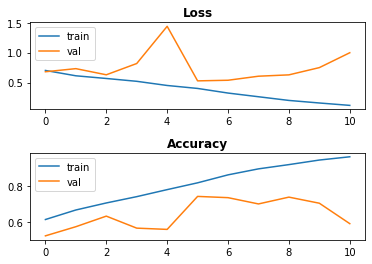



Confusion Matrix, without normalization


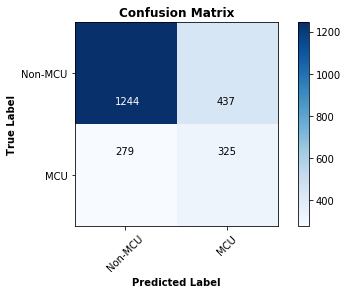



              precision    recall  f1-score   support

     Non-MCU       0.82      0.74      0.78      1681
         MCU       0.43      0.54      0.48       604

    accuracy                           0.69      2285
   macro avg       0.62      0.64      0.63      2285
weighted avg       0.71      0.69      0.70      2285



In [39]:
print(mf.evaluate_test(model_baseline_batch_hidden, history_baseline_batch_hidden, class_labels, train_images, test_images, train_y, test_y))

## Batch Normalization after Activation
Batch Normalization between the Convolution and Pooling layers reduced MCU recall to a coin-flip. Let's try Batch Normalization after the classifier's relu layer.

In [8]:
model_baseline_batch_activation = models.Sequential()
model_baseline_batch_activation.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_baseline_batch_activation.add(layers.MaxPooling2D((2, 2)))

model_baseline_batch_activation.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_baseline_batch_activation.add(layers.MaxPooling2D((2, 2)))

model_baseline_batch_activation.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_baseline_batch_activation.add(layers.MaxPooling2D((2, 2)))

model_baseline_batch_activation.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_baseline_batch_activation.add(layers.MaxPooling2D((2, 2)))

model_baseline_batch_activation.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_baseline_batch_activation.add(layers.MaxPooling2D((2, 2)))

model_baseline_batch_activation.add(layers.Flatten())
model_baseline_batch_activation.add(layers.Dense(64, activation='relu'))
model_baseline_batch_activation.add(layers.BatchNormalization())
model_baseline_batch_activation.add(layers.Dense(1, activation='sigmoid'))

model_baseline_batch_activation.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [9]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_baseline_batch_activation = model_baseline_batch_activation.fit(train_images,
                                                 train_y,
                                                 epochs=50,
                                                 batch_size=50,
                                                 validation_data=(val_images, val_y),
                                                 callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 8s 2ms/step - loss: 0.6751 - acc: 0.5836 - val_loss: 0.6420 - val_acc: 0.5544
Epoch 2/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6322 - acc: 0.6474 - val_loss: 2.2095 - val_acc: 0.4731
Epoch 3/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6193 - acc: 0.6626 - val_loss: 1.3018 - val_acc: 0.4887
Epoch 4/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5742 - acc: 0.7020 - val_loss: 0.6713 - val_acc: 0.5495
Epoch 5/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5425 - acc: 0.7247 - val_loss: 1.8168 - val_acc: 0.5064
Epoch 6/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5162 - acc: 0.7447 - val_loss: 0.8995 - val_acc: 0.5485


Accuracy 
 Train: 0.566, Test: 0.393
Loss 
 Train: 0.829, Test: 1.179 



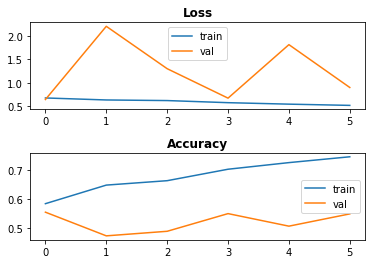



Confusion Matrix, without normalization


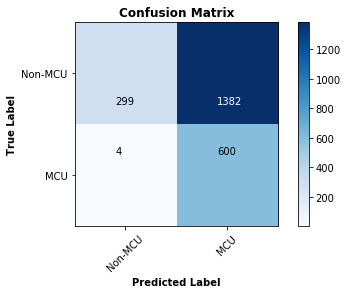



              precision    recall  f1-score   support

     Non-MCU       0.99      0.18      0.30      1681
         MCU       0.30      0.99      0.46       604

    accuracy                           0.39      2285
   macro avg       0.64      0.59      0.38      2285
weighted avg       0.81      0.39      0.34      2285



In [10]:
print(mf.evaluate_test(model_baseline_batch_activation, history_baseline_batch_activation, class_labels, train_images, test_images, train_y, test_y))

Applying Batch Normalization after the classifier's relu Activation Layer resulted in nearly all images classified as MCUs. We won't try Batch Normalization during the modeling process.

In [1]:
# this may need to be run each time a Jupyter notebook server is started
pip install Pillow --user

     |████████████████████████████████| 2.1MB 1.6MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# this may need to be run each time a Jupyter notebook server is started
pip install keras --user

     |████████████████████████████████| 378kB 1.1MB/s eta 0:00:01
     |████████████████████████████████| 276kB 1.3MB/s eta 0:00:01
Failed to build pyyaml
    Running setup.py install for pyyaml ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# this may need to be run each time a Jupyter notebook server is started
pip install sklearn --user

     |████████████████████████████████| 7.3MB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 307kB 869kB/s eta 0:00:01
Failed to build sklearn
    Running setup.py install for sklearn ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
